In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import yfinance as yf

In [4]:
# Define the ticker symbol for Apple
ticker = 'AAPL'

# Get the data of the stock
data = yf.download(ticker, start="2020-01-01", )
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1221, 6)


In [5]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02 00:00:00+00:00,72.876114,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03 00:00:00+00:00,72.167587,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06 00:00:00+00:00,72.742661,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07 00:00:00+00:00,72.400558,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08 00:00:00+00:00,73.565186,75.797501,76.110001,74.290001,74.290001,132079200


### PCA weights from a risk distribution R

In [6]:
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    eVal, eVec = np.linalg.eig(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, loads.reshape(-1, 1))
    return wghts

In [7]:
matrixSize = 3 
np.random.seed(0)
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())
pcaWeights(B)

array([[ 4.91041938],
       [-3.132718  ],
       [-1.73855105]])

#### The symmetric CUSUM Filter

In [36]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i].values[0]), min(0, sNeg + diff.loc[i].values[0])
        if sPos > h:
            sPos = 0
            tEvents.append(i)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
    return tEvents

In [42]:
prices = data['Close']
events = getTEvents(prices, 5)

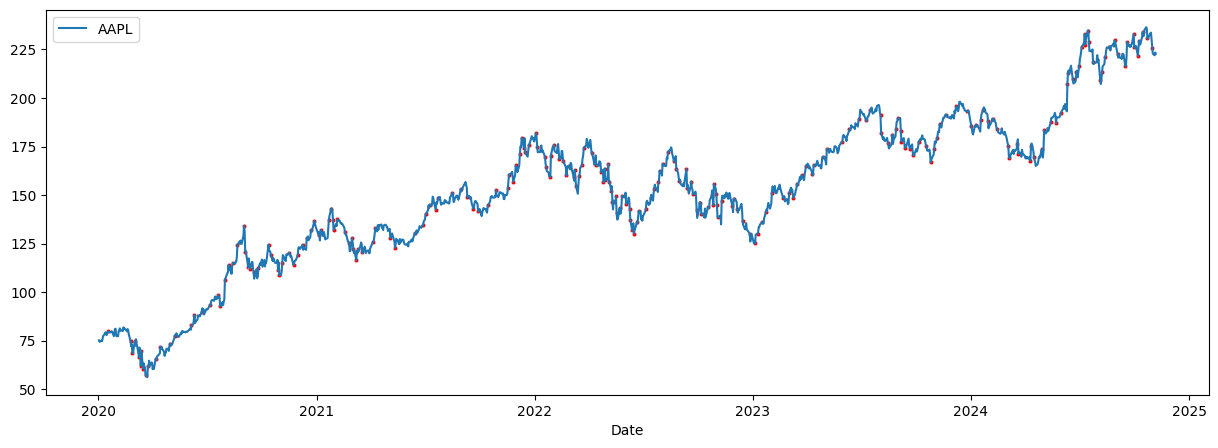

In [55]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
sns.scatterplot(x=pd.Series(events),y=data.loc[events,'Close'].values.reshape(-1), s=10, color="red")
plt.show()

## Exercise

In [58]:
## get the data
es_data = yf.download("ES=F", period="1Y", interval="1d") 

[*********************100%***********************]  1 of 1 completed


In [59]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F,ES=F
Date,,,,,,
2023-11-07 00:00:00+00:00,4396.00,4396.00,4403.25,4366.00,4380.00,1371257
2023-11-08 00:00:00+00:00,4399.50,4399.50,4407.75,4375.00,4397.50,1390288
2023-11-09 00:00:00+00:00,4362.25,4362.25,4413.00,4357.75,4393.25,1972630
2023-11-10 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4364.50,1752002
2023-11-13 00:00:00+00:00,4425.25,4425.25,4436.75,4407.25,4425.75,1276182


In [67]:
es_data.columns = es_data.columns.get_level_values(0)

In [70]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-11-07 00:00:00+00:00,4396.00,4396.00,4403.25,4366.00,4380.00,1371257
2023-11-08 00:00:00+00:00,4399.50,4399.50,4407.75,4375.00,4397.50,1390288
2023-11-09 00:00:00+00:00,4362.25,4362.25,4413.00,4357.75,4393.25,1972630
2023-11-10 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4364.50,1752002
2023-11-13 00:00:00+00:00,4425.25,4425.25,4436.75,4407.25,4425.75,1276182


In [73]:
def group_bars(ticks, bar_index):
    ticks = ticks.reset_index()
    ticks.columns = ticks.columns.str.lower()
    ticks_gp = ticks.groupby(bar_index)
    df = pd.DataFrame()
    cols = ticks.columns
    if 'open' in cols:
        df['Open'] = ticks_gp['open'].first()
        #df['Num ticks'] = ticks_gp['open'].count()
    if 'high' in cols:
        df['High'] = ticks_gp['high'].max()
    if 'low' in cols:
        df['Low'] = ticks_gp['low'].min()
    if 'close' in cols:
        df['Close'] = ticks_gp['close'].last()
    if 'adj close' in cols:
        df['Adj Close'] = ticks_gp['adj close'].last()
    if 'volume' in cols:
        df['Volume'] = ticks_gp['volume'].sum()
    #df['Num ticks'] = ticks_gp.size()
    return df

In [78]:
p = 0
index = []
for i in es_data.index:
    if p % 11 == 0:
        index.append(i)
    p += 1
index = pd.Series(index)
df = group_bars(es_data, index)

In [79]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
2023-11-07 00:00:00+00:00,4380.00,4403.25,4366.00,4396.00,4396.00,1371257
2023-11-22 00:00:00+00:00,4397.50,4407.75,4375.00,4399.50,4399.50,1390288
2023-12-07 00:00:00+00:00,4393.25,4413.00,4357.75,4362.25,4362.25,1972630
2023-12-22 00:00:00+00:00,4364.50,4435.50,4354.25,4430.50,4430.50,1752002
2024-01-10 00:00:00+00:00,4425.75,4436.75,4407.25,4425.25,4425.25,1276182


In [77]:
es_data.head(20)

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-11-07 00:00:00+00:00,4396.00,4396.00,4403.25,4366.00,4380.00,1371257
2023-11-08 00:00:00+00:00,4399.50,4399.50,4407.75,4375.00,4397.50,1390288
2023-11-09 00:00:00+00:00,4362.25,4362.25,4413.00,4357.75,4393.25,1972630
2023-11-10 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4364.50,1752002
2023-11-13 00:00:00+00:00,4425.25,4425.25,4436.75,4407.25,4425.75,1276182
2023-11-14 00:00:00+00:00,4511.00,4511.00,4524.25,4420.25,4427.25,1901847
2023-11-15 00:00:00+00:00,4519.25,4519.25,4541.25,4510.75,4515.50,1573452
2023-11-16 00:00:00+00:00,4523.25,4523.25,4529.50,4501.75,4514.25,1491734
2023-11-17 00:00:00+00:00,4527.50,4527.50,4539.50,4512.75,4527.75,1331912


In [81]:
yf.__version__

'0.2.48'